In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [2]:
def load_and_prep(filename):
    # Load
    if 'xlsx' in filename:
        df = pd.read_excel(filename)
    else:
        df = pd.read_csv(filename)

    # Transform
    df_total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])
    df_long = df_total.melt(var_name='Date_Str', value_name='Value')
    df_long['Date'] = pd.to_datetime(df_long['Date_Str'], format='%b-%Y')
    df_long = df_long.sort_values('Date').set_index('Date')
    return df_long['Value']

In [3]:
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

In [4]:
def train_lstm_model(train_data, look_back=3, epochs=50):
    # Scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

    # Create Sequences
    X_train, y_train = create_lstm_dataset(train_scaled, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

    # Build Model
    model = Sequential()
    model.add(LSTM(80, input_shape=(1, look_back), activation='relu',return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(30, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # Train
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=2, verbose=0, callbacks=[es])

    return model, scaler

In [5]:
def forecast_lstm(model, scaler, train_data, steps, look_back=3):
    # Recursive Forecasting
    curr_seq = scaler.transform(train_data[-look_back:].reshape(-1, 1))
    forecast = []

    for _ in range(steps):
        input_seq = curr_seq.reshape(1, 1, look_back)
        pred = model.predict(input_seq, verbose=0)
        forecast.append(pred[0, 0])
        curr_seq = np.append(curr_seq[1:], pred).reshape(-1, 1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

In [6]:
def run_comparison(name, filename, sarima_order, seasonal_order, use_log=False):
    print(f"\n--- Processing {name} Data ---")

    # 1. Data Prep
    series = load_and_prep(filename)
    test_len = 12
    train = series.iloc[:-test_len]
    test = series.iloc[-test_len:]

    # Apply Log
    if use_log:
        train_model_input = np.log(train)
        test_model_target = np.log(test)
    else:
        train_model_input = train
        test_model_target = test

    # --------------------------------------
    # Model A: SARIMAX
    # --------------------------------------
    print("Running Model 1: SARIMAX...")
    model_s = SARIMAX(train_model_input, order=sarima_order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
    fit_s = model_s.fit(disp=False)
    pred_s = fit_s.forecast(steps=test_len)

    # --------------------------------------
    # Model B: Pure LSTM
    # --------------------------------------
    print("Running Model 2: Pure LSTM...")
    look_back = 4
    lstm_model, lstm_scaler = train_lstm_model(train_model_input.values, look_back=look_back)
    pred_l = forecast_lstm(lstm_model, lstm_scaler, train_model_input.values, test_len, look_back)
    pred_l = pd.Series(pred_l, index=test.index)

    # --------------------------------------
    # Model C: Hybrid (SARIMAX + LSTM Residuals)
    # --------------------------------------
    print("Running Model 3: Hybrid (SARIMAX + LSTM)...")
    # Get residuals from training
    train_resid = train_model_input - fit_s.fittedvalues
    # Train LSTM on Residuals
    hybrid_lstm, hybrid_scaler = train_lstm_model(train_resid.values, look_back=look_back)
    # Forecast Residuals
    pred_resid = forecast_lstm(hybrid_lstm, hybrid_scaler, train_resid.values, test_len, look_back)
    # Add to SARIMAX Forecast
    pred_h = pred_s + pred_resid

    # --------------------------------------
    # Inverse Transform & Evaluation
    # --------------------------------------
    if use_log:
        final_s = np.exp(pred_s)
        final_l = np.exp(pred_l)
        final_h = np.exp(pred_h)
    else:
        final_s = pred_s
        final_l = pred_l
        final_h = pred_h

    rmse_s = np.sqrt(mean_squared_error(test, final_s))
    rmse_l = np.sqrt(mean_squared_error(test, final_l))
    rmse_h = np.sqrt(mean_squared_error(test, final_h))

    print(f"RESULTS ({name}):")
    print(f"  SARIMAX RMSE: {rmse_s:.4f}")
    print(f"  LSTM RMSE:    {rmse_l:.4f}")
    print(f"  Hybrid RMSE:  {rmse_h:.4f}")

    # --------------------------------------
    # Visualization
    # --------------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual Data', color='black', linewidth=2, marker='o')
    plt.plot(test.index, final_s, label=f'SARIMAX (RMSE: {rmse_s:.2f})', linestyle='--')
    plt.plot(test.index, final_l, label=f'LSTM (RMSE: {rmse_l:.2f})', linestyle='--')
    plt.plot(test.index, final_h, label=f'Hybrid (RMSE: {rmse_h:.2f})', linewidth=2)

    plt.title(f'Model Comparison: {name} Forecasting')
    plt.ylabel('Value (Million USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return rmse_s, rmse_l, rmse_h


--- Processing Copper export Data ---
Running Model 1: SARIMAX...
Running Model 2: Pure LSTM...
Running Model 3: Hybrid (SARIMAX + LSTM)...
RESULTS (Copper export):
  SARIMAX RMSE: 36.7360
  LSTM RMSE:    42.1641
  Hybrid RMSE:  41.6252


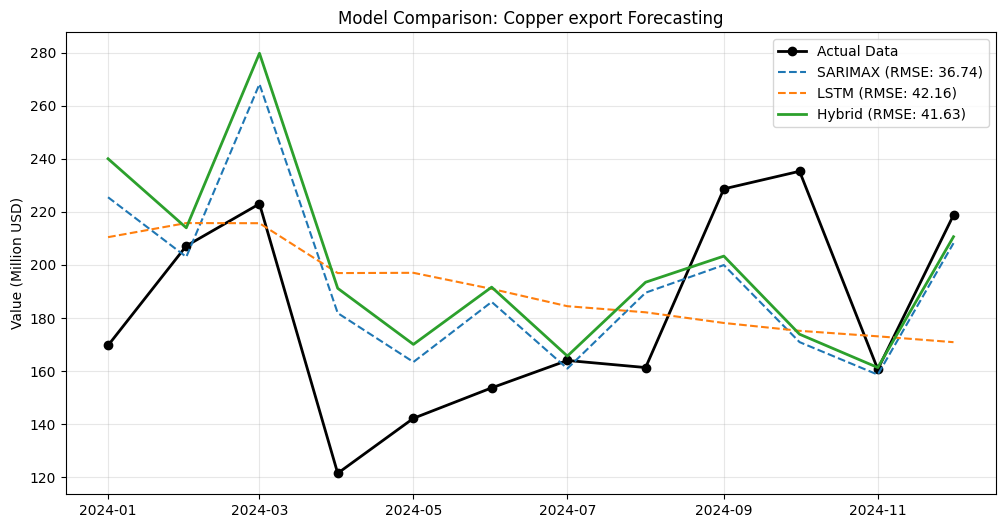

In [7]:
rmse_imp_s, rmse_imp_l, rmse_imp_h = run_comparison(
    name="Copper export",
    filename='Copper export Forecasting.xlsx',
    sarima_order=(6, 0, 5),
    seasonal_order=(1, 1, 1, 12),
    use_log=False
)

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [15]:
df = pd.read_excel('Copper export Forecasting.xlsx')
df_total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])

df2 = pd.read_excel('Copper export 2025.xlsx')
df_total2 = df2[df2['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])

In [16]:
df_long = df_total.melt(var_name='Date_Str', value_name='Value')
df_long2 = df_total2.melt(var_name='Date_Str', value_name='Value')

In [17]:
df_long['Date'] = pd.to_datetime(df_long['Date_Str'], format='%b-%Y')
df_long = df_long.sort_values('Date').set_index('Date')
series = df_long['Value']

df_long2['Date'] = pd.to_datetime(df_long2['Date_Str'], format='%b-%Y')
df_long2 = df_long2.sort_values('Date').set_index('Date')
series2 = df_long2['Value']

In [18]:
result = adfuller(series.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}") # data is stationary d=0

ADF Statistic: -3.8286
p-value: 0.0026


In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

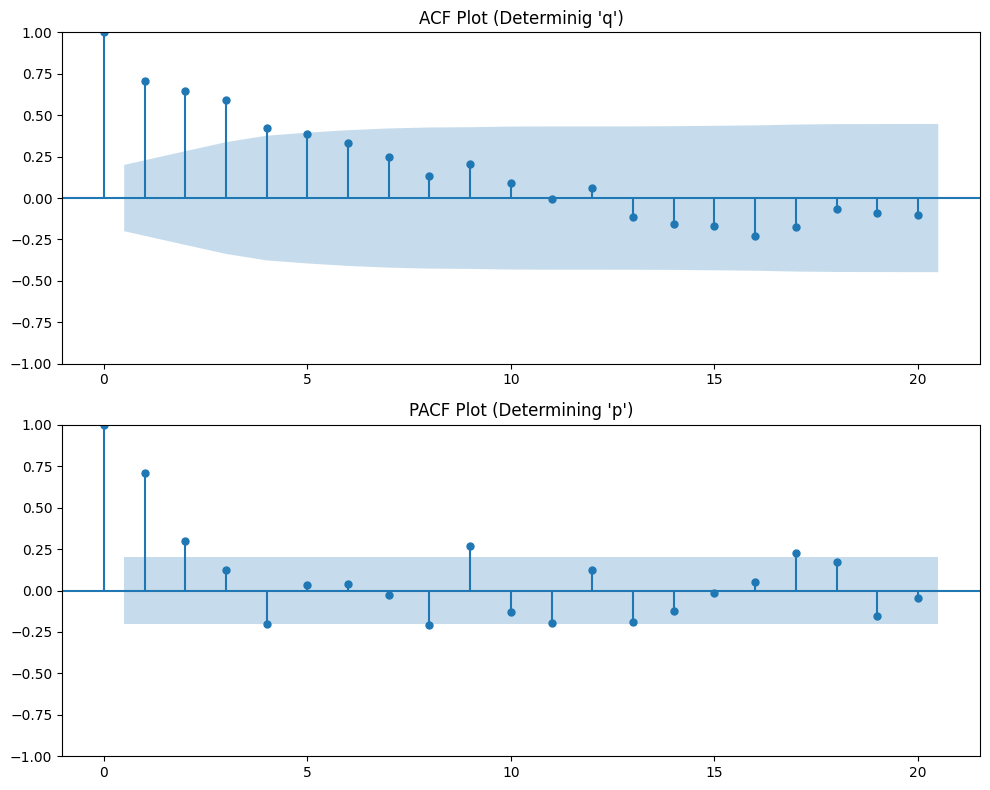

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF (Determine q)
plot_acf(series, lags=20, ax=ax1, title="ACF Plot (Determinig 'q')") # q=11

# Plot PACF (Determine p)
plot_pacf(series, lags=20, ax=ax2, title="PACF Plot (Determining 'p')") # p=6

plt.tight_layout()
plt.show()

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [19]:
train_data = series
test_data = series2

In [27]:
model = SARIMAX(train_data,
                order=(6, 0, 5),
                seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False)

# validation
forecast = model_fit.get_forecast(steps=12)
pred_values = forecast.predicted_mean
conf_int = forecast.conf_int()


rmse = np.sqrt(mean_squared_error(test_data, pred_values))
print(f"Model Performance (RMSE): {rmse:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model Performance (RMSE): 88.14


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
pred_values

,predicted_mean
2025-01-01,192.225309
2025-02-01,151.105425
2025-03-01,234.628140
2025-04-01,134.020990
2025-05-01,153.851886
2025-06-01,173.868129
2025-07-01,161.773878
2025-08-01,178.111819
2025-09-01,193.342647
2025-10-01,166.710137


In [29]:
test_data

,Value
Date,
2025-01-01,209.92
2025-02-01,155.45
2025-03-01,187.22
2025-04-01,167.03
2025-05-01,173.62
2025-06-01,165.19
2025-07-01,217.89
2025-08-01,204.73
2025-09-01,252.12
